In [1]:
from einops import rearrange
import torch
import torchvision.transforms as transforms
from torch import nn
import torch.nn.functional as F
import numpy as np
from torchvision.datasets import ImageFolder
from ncut_pytorch import NCUT, rgb_from_tsne_3d
from matplotlib import pyplot as plt
import os
import glob
import matplotlib.pyplot as plt
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration, Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoModel, AutoProcessor, CLIPTokenizer, CLIPTextModelWithProjection
from qwen_vl_utils import process_vision_info
import requests
from PIL import Image, ImageOps
import accelerate
import gc
from diffusers import StableDiffusion3Pipeline, AutoencoderKL, SD3Transformer2DModel
import functools

/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-04 15:35:18.932967: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-04 15:35:18.933014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-04 15:35:18.949503: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025

In [2]:
image_files = sorted(glob.glob("data/*_base.png") + glob.glob("data/*_test.png"))

images = []
for image_file in image_files:
    image = Image.open(image_file).convert("RGB")
    images.append(image)

In [3]:
all_features = torch.load("all_features.pt")

In [4]:
clustered_features = {}
for model, features in all_features.items():
    eigenvectors, _ = NCUT(num_eig=20, device="cuda:0").fit_transform(features.reshape(-1, features.shape[-1]).to(torch.float))
    _, rgb = rgb_from_tsne_3d(eigenvectors, device="cuda:0")
    rgb = rgb.reshape(features.shape[:-1] + (3,))
    clustered_features[model] = rgb

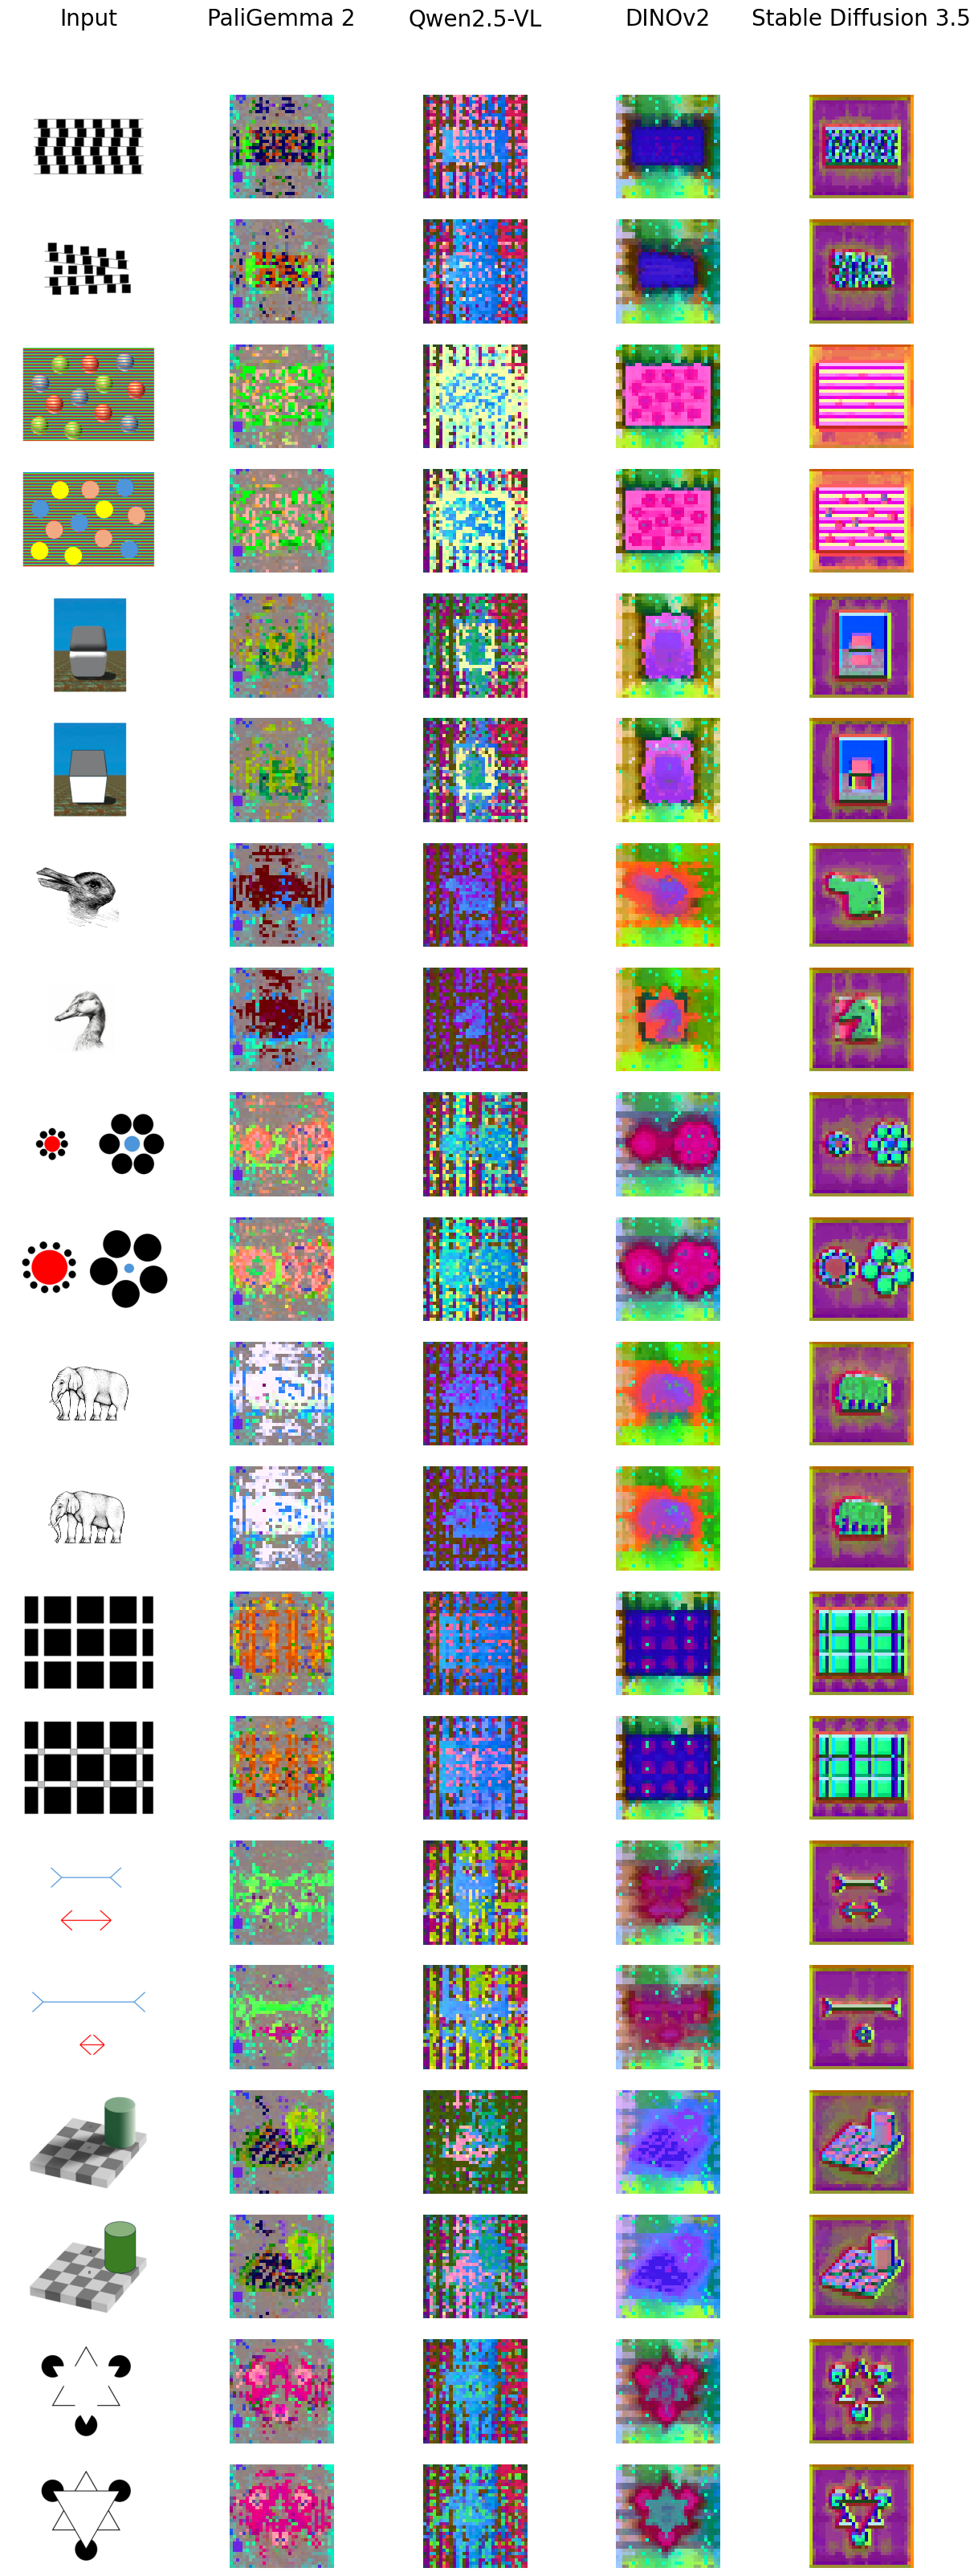

In [5]:
fig, ax = plt.subplots(20, 5, figsize=(15, 40))
for a in ax.flatten():
    a.axis("off")
    
for j in range(20):
    ax[j,0].imshow(images[j])
    ax[j,1].imshow(clustered_features["paligemma_features"][j])
    ax[j,2].imshow(clustered_features["qwen_features"][j])
    ax[j,3].imshow(clustered_features["dino_features"][j])
    ax[j,4].imshow(clustered_features["stable_diffusion_features"][j])

col_titles = ["Input", "PaliGemma 2", "Qwen2.5-VL", "DINOv2", "Stable Diffusion 3.5"]
for j, title in enumerate(col_titles):
    pos = ax[0,j].get_position()
    x = pos.x0 + pos.width / 2
    y = 0.9
    fig.text(x, y, title, ha="center", va="bottom", fontsize=20)

plt.savefig(f"figs/features_all.png", bbox_inches="tight")

plt.show()

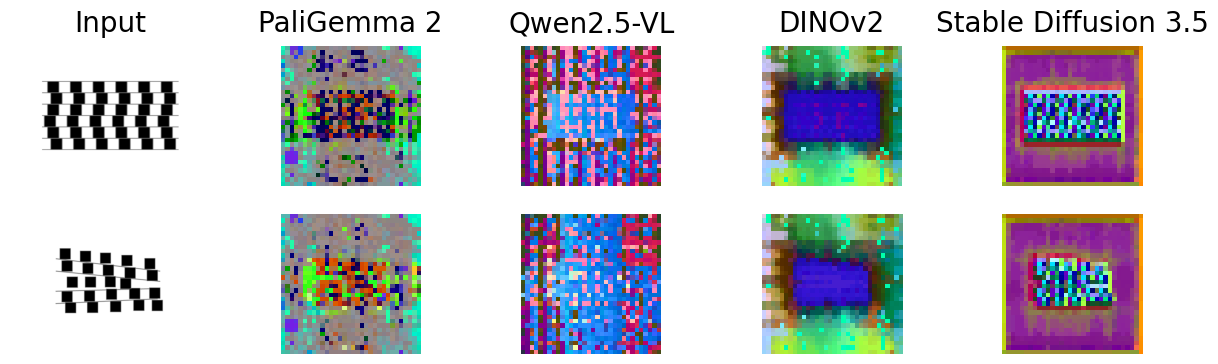

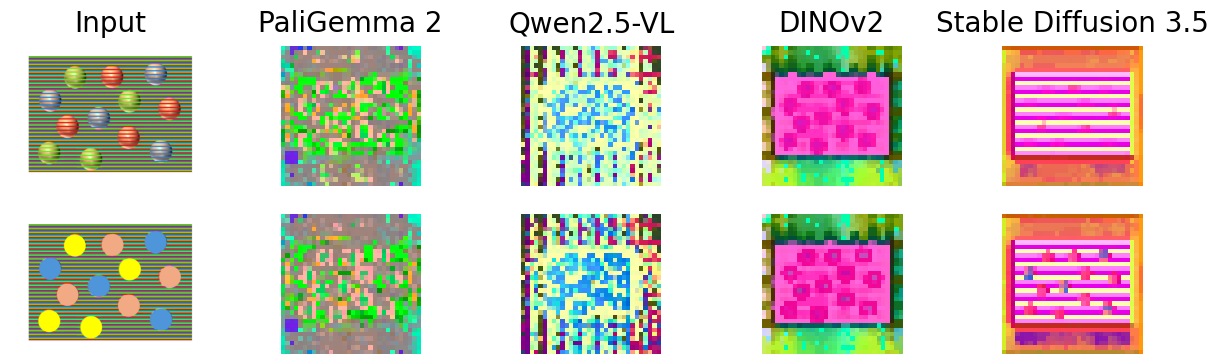

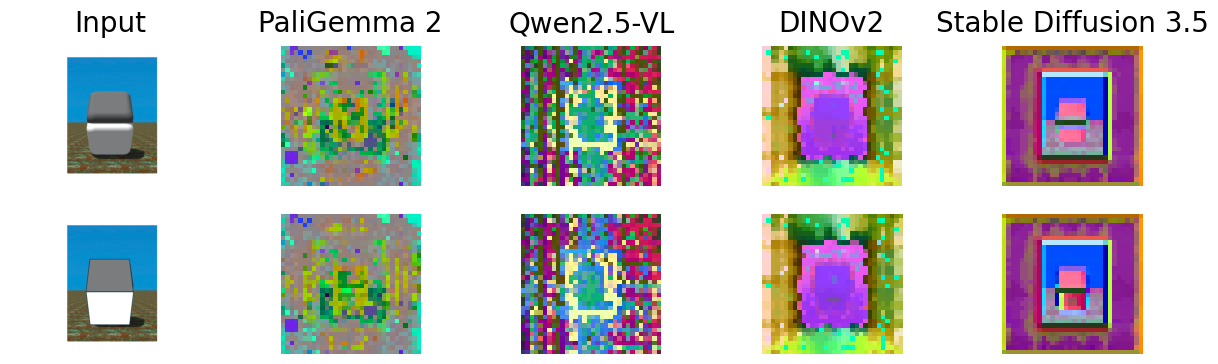

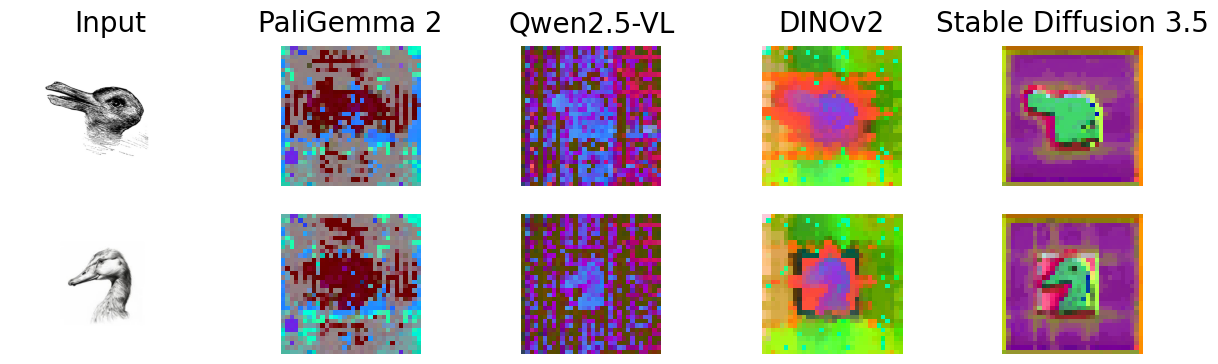

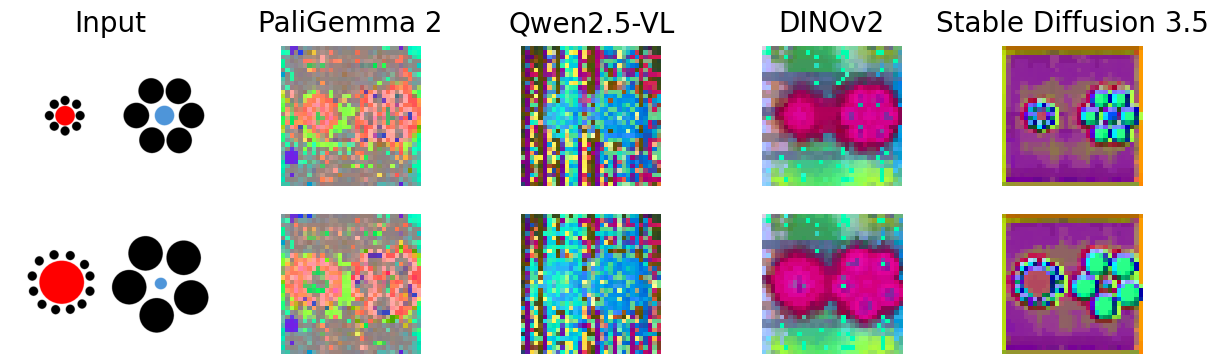

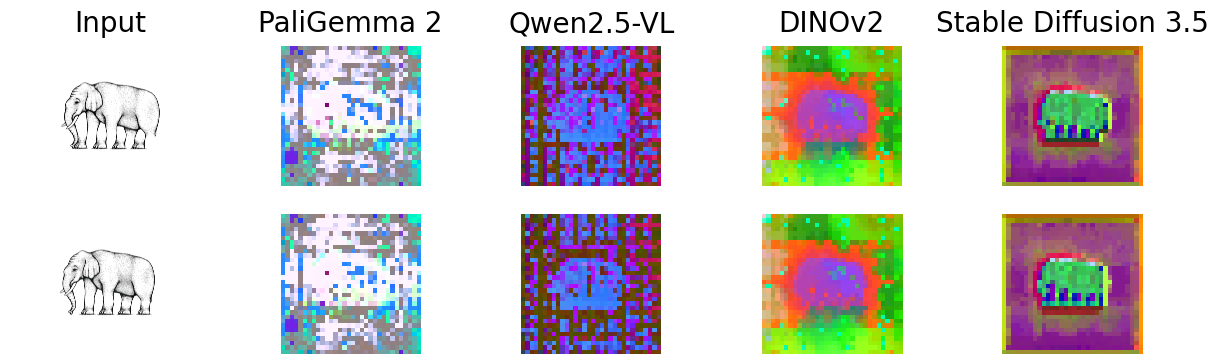

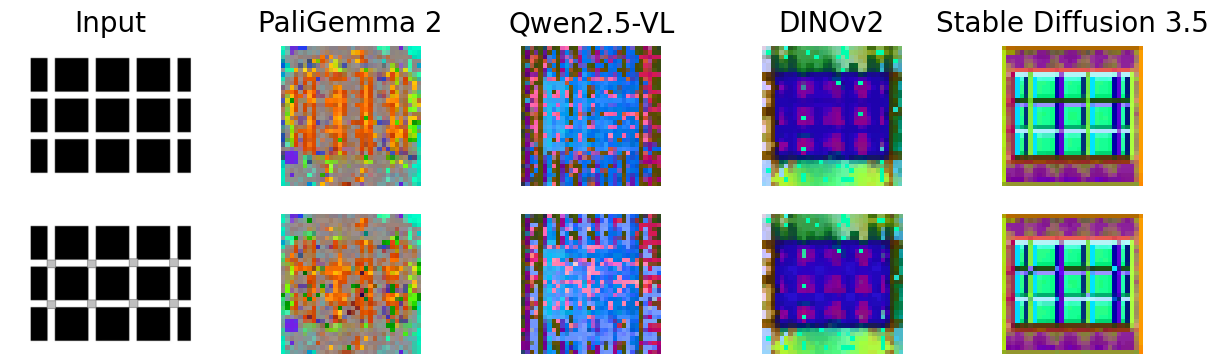

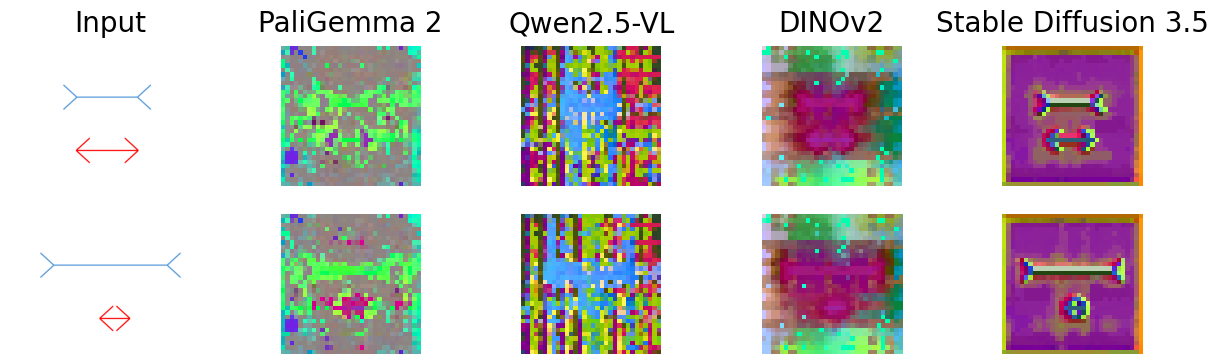

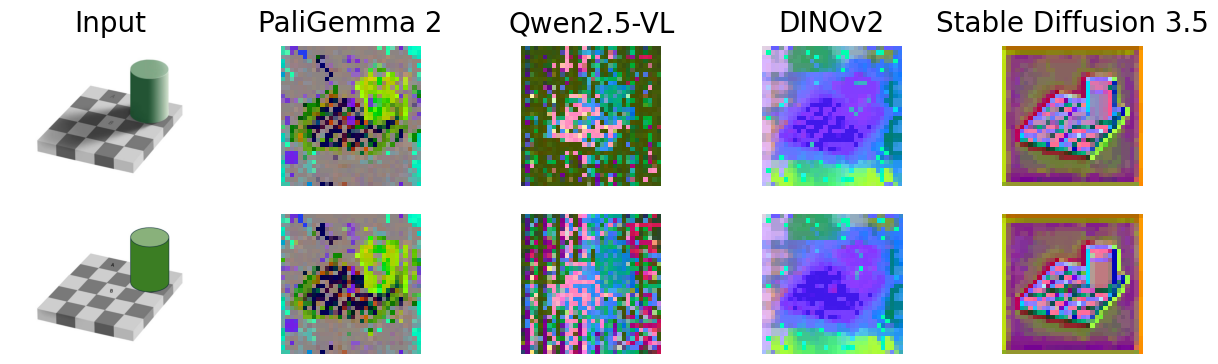

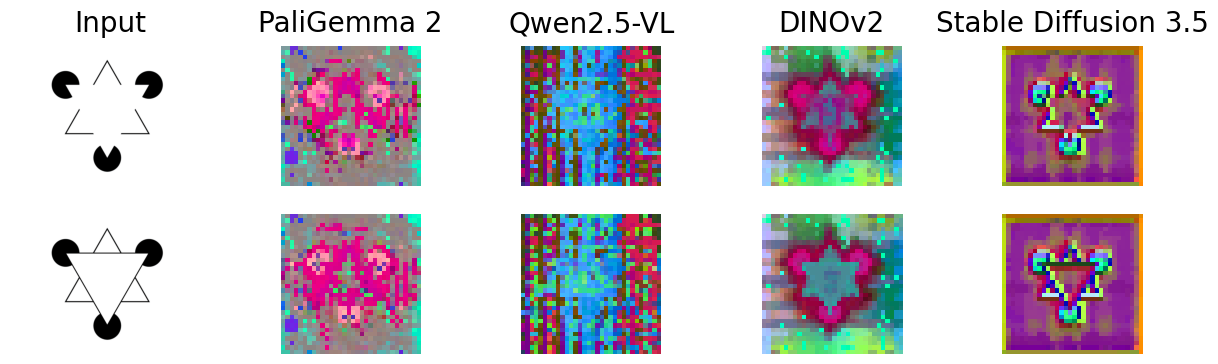

In [6]:
n = 2
for i in range(len(images) // n):
    fig, ax = plt.subplots(n, 5, figsize=(15, n * 2))
    for a in ax.flatten():
        a.axis("off")
        
    for j in range(n):
        ax[j,0].imshow(images[n*i+j])
        ax[j,1].imshow(clustered_features["paligemma_features"][n*i+j])
        ax[j,2].imshow(clustered_features["qwen_features"][n*i+j])
        ax[j,3].imshow(clustered_features["dino_features"][n*i+j])
        ax[j,4].imshow(clustered_features["stable_diffusion_features"][n*i+j])
    
    col_titles = ["Input", "PaliGemma 2", "Qwen2.5-VL", "DINOv2", "Stable Diffusion 3.5"]
    for j, title in enumerate(col_titles):
        pos = ax[0,j].get_position()
        x = pos.x0 + pos.width / 2
        y = 0.9
        fig.text(x, y, title, ha="center", va="bottom", fontsize=20)
    
    plt.savefig(f"figs/features_{i}.png", bbox_inches="tight")

    plt.show()

In [12]:
def nn_similarity(feat1, feat2):    
    sims1 = torch.zeros((feat1.shape[0]), device=feat1.device)
    for i in range(feat1.shape[0]):
        sims1[i] = F.cosine_similarity(feat1[i:i+1], feat2, dim=1).max()

    sims2 = torch.zeros((feat2.shape[0]), device=feat2.device)
    for i in range(feat2.shape[0]):
        sims2[i] = F.cosine_similarity(feat2[i:i+1], feat1, dim=1).max()

    return ((sims1.mean() + sims2.mean()) / 2).item()

In [13]:
all_similarities = {}
for model, features in all_features.items():
    sims = np.zeros((features.shape[0], features.shape[0]))
    
    for i in range(features.shape[0]):
        feat1 = features[i].reshape(-1, features.shape[-1]).to("cuda:0")
        
        for j in range(features.shape[0]):
            feat2 = features[j].reshape(-1, features.shape[-1]).to("cuda:0")
            
            sims[i,j] = nn_similarity(feat1, feat2)

    all_similarities[model] = sims

np.save("all_similarities.npy", all_similarities)

In [6]:
all_similarities = np.load("all_similarities.npy", allow_pickle=True).item()

In [17]:
paligemma_illusionillusion_sim = []
qwen_illusionillusion_sim = []
dino_illusionillusion_sim = []
stable_diffusion_illusionillusion_sim = []

paligemma_otherillusion_sim = []
qwen_otherillusion_sim = []
dino_otherillusion_sim = []
stable_diffusion_otherillusion_sim = []

for i in range(0, 20, 2):
    paligemma_illusionillusion_sim.append(all_similarities["paligemma_features"][i][i+1])
    qwen_illusionillusion_sim.append(all_similarities["qwen_features"][i][i+1])
    dino_illusionillusion_sim.append(all_similarities["dino_features"][i][i+1])
    stable_diffusion_illusionillusion_sim.append(all_similarities["stable_diffusion_features"][i][i+1])

    idx = list(range(0, 20, 2)).remove(i)
    paligemma_otherillusion_sim.append(all_similarities["paligemma_features"][i][idx].mean())
    qwen_otherillusion_sim.append(all_similarities["qwen_features"][i][idx].mean())
    dino_otherillusion_sim.append(all_similarities["dino_features"][i][idx].mean())
    stable_diffusion_otherillusion_sim.append(all_similarities["stable_diffusion_features"][i][idx].mean())

print("paligemma illusion / illusion-illusion:", np.mean(paligemma_illusionillusion_sim), paligemma_illusionillusion_sim, )
print("paligemma illusion / other illusions:", np.mean(paligemma_otherillusion_sim), paligemma_otherillusion_sim)
print()

print("qwen illusion / illusion-illusion:", np.mean(qwen_illusionillusion_sim), qwen_illusionillusion_sim)
print("qwen illusion / other illusions:", np.mean(qwen_otherillusion_sim), qwen_otherillusion_sim)
print()

print("dino illusion / illusion-illusion:", np.mean(dino_illusionillusion_sim), dino_illusionillusion_sim)
print("dino illusion / other illusions:", np.mean(dino_otherillusion_sim), dino_otherillusion_sim)
print()

print("stable diffusion illusion / illusion-illusion:", np.mean(stable_diffusion_illusionillusion_sim), stable_diffusion_illusionillusion_sim)
print("stable diffusion illusion / other illusions:", np.mean(stable_diffusion_otherillusion_sim), stable_diffusion_otherillusion_sim)

paligemma illusion / illusion-illusion: 0.8589652299880981 [0.814858615398407, 0.8419424891471863, 0.8592432141304016, 0.7899126410484314, 0.8827751874923706, 0.9372498393058777, 0.8379806280136108, 0.8761082887649536, 0.9011018872261047, 0.8484795093536377]
paligemma illusion / other illusions: 0.7174952006340026 [0.7330562144517898, 0.7061111927032471, 0.7157150566577911, 0.7018581032752991, 0.7198845833539963, 0.704170960187912, 0.715611782670021, 0.7268981248140335, 0.7233175367116929, 0.7283284515142441]

qwen illusion / illusion-illusion: 0.8031320452690125 [0.8121037483215332, 0.8108401298522949, 0.8312903642654419, 0.694169282913208, 0.8507848381996155, 0.7890337705612183, 0.7804707288742065, 0.8741909861564636, 0.7582279443740845, 0.8302086591720581]
qwen illusion / other illusions: 0.6574378144741059 [0.6891552716493606, 0.6308455467224121, 0.6619480937719345, 0.6395974367856979, 0.6741192758083343, 0.6582868963479995, 0.6576626241207123, 0.6615462929010392, 0.607987964153289